In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.integrate import quad
from mpl_toolkits.mplot3d import Axes3D

variables = {
    'k1': 1.45e-2,
    'k2': 2.76e-1,
    'k3': 6.07e-3,
    'k4': 2.35e-4,
    'k5': 9.49e-2,
    'k6': 1.93e-1,
    'k7': 1.15,
    'k8': 7.27,
    'k9': 0,
    'k10': 0,
    'k11': 3.83e-2,
    'k12': 2.84e-1,
    'k13': 0,
    'sigma': 1.34,
    'K_M': 13.2,
    'Gbpl': 5,
    'Ibpl': 5,
    'gbliv': 0.043,
    'Gthpl': 9,
    'vG': 17/70,
    'vI': 13/70,
    'beta': 1,
    'f': 0.005551,
    'tau_i': 31,
    't_start': 0,
    't_end': 30,
    'tau_d': 3,
    'c1': 0.1,
    'h': 1,
    't_half': 1,
    'a': 1,
    'b': 1
}

usa = lambda t: 1

inputs = {
    'Dmeal': 75,
    'Mb': 150,
    'usa': usa,
    'Ula': lambda t: 1,
    'h': 2
}

def MGgut(t):
    D_meal = inputs['Dmeal']
    k1 = variables['k1']
    sigma = variables['sigma']
    return D_meal * np.exp(-(k1*t)**sigma)

def dGpl_dt(t, Gpl, Ipl, Irem, Usc1, Usc2):
    def gliv(Gpl, Irem):
        gbliv = variables['gbliv']
        k3 = variables['k3']
        Gbpl = variables['Gbpl']
        k4 = variables['k4']
        beta = variables['beta'] 
        return gbliv - k3 * (Gpl - Gbpl) - k4 * beta * Irem

    def ggut(MGgut):
        k2 = variables['k2']
        f = variables['f']
        vG = variables['vG']
        Mb = inputs['Mb']
        return k2 * (f / (vG * Mb)) * MGgut

    def gnonit(Gpl):
        gbliv = variables['gbliv']
        KM = variables['K_M']
        Gbpl = variables['Gbpl']
        return gbliv * ((KM + Gbpl) / Gbpl) * (Gpl / (KM + Gpl))

    def git(Gpl, Irem):
        k5 = variables['k5']
        beta = variables['beta']
        KM = variables['K_M']
        return k5 * beta * Irem * (Gpl / (KM + Gpl))

    def gren(Gpl):
        c1 = variables['c1']
        vG = variables['vG']
        Mb = inputs['Mb']
        Gthpl = variables['Gthpl']
        return 0 if Gpl < Gthpl else (c1 / (vG * Mb)) * (Gpl - Gthpl)

    return gliv(Gpl, Irem) + ggut(MGgut(t)) - gnonit(Gpl) - git(Gpl, Irem) - gren(Gpl)

def dUsc1_dt(t, Usc1):
        k10 = variables['k10']
        usa = inputs['usa']
        return usa(t) - k10 * Usc1

def dUsc2_dt(t, Usc1, Usc2):
        k9 = variables['k9']
        k10 = variables['k10']
        return k10 * Usc1 - k9 * Usc2

def dIpl_dt(t, Gpl, Ipl, Irem, Usc1, Usc2):

    def ipnc(t, Gpl, dGpl_dt):
        Gbpl = variables['Gbpl']
        beta = variables['beta']
        k6 = variables['k6']
        k7 = variables['k7']
        tau_i = variables['tau_i']
        k8 = variables['k8']
        tau_d = variables['tau_d']
        t_start = variables['t_start']
        t_end = variables['t_end']

        if np.isscalar(dGpl_dt):
            dGpl_dt = np.array([dGpl_dt])  # Convert scalar to array

        def integrand(x):
            return np.squeeze(Gpl - Gbpl)

        integral_term, _ = quad(integrand, t_start, t_end)
        return (1 / beta) * (k6 * np.squeeze(Gpl - Gbpl) + (k7 / tau_i) * integral_term + (k7 / tau_i) * Gbpl + (k8 * tau_d) * dGpl_dt)


    def isa(t, Usc2):
        k9 = variables['k9']
        vI = variables['vI']
        Mb = inputs['Mb']
        return k9 * (1 / (vI * Mb)) * Usc2

    def ila(t, Ula):
        h = variables['h']
        t_half = variables['t_half']
        vI = variables['vI']
        Mb = inputs['Mb']
        return ((h * (t_half ** h) * (t ** (h - 1))) / (((t_half ** h) + (t ** h)) ** 2)) * ((1 / (vI * Mb)) * Ula(t))

    def iliv(t, Gpl, Ipl):
        k7 = variables['k7']
        beta = variables['beta']
        tau_i = variables['tau_i']
        Ibpl = variables['Ibpl']
        return k7 * (variables['Gbpl'] / (beta * tau_i * Ibpl)) * Ipl

    def irem(t, Ipl):
        k11 = variables['k11']
        Ibpl = variables['Ibpl']
        return k11 * (Ipl - Ibpl)

    return ipnc(t, Gpl, dGpl_dt(t, Gpl, Ipl, Irem, Usc1, Usc2)) + isa(t, Usc2) + ila(t, inputs['Ula']) - iliv(t, Gpl, Ipl) - irem(t, Ipl)



def dIrem_dt(t, Gpl, Ipl, Irem, Usc1, Usc2):
    def ipl(t, Ipl):
        k11 = variables['k11']
        Ibpl = variables['Ibpl']
        return k11 * (Ipl - Ibpl)

    def iit(t, Irem):
        k12 = variables['k12']
        return k12 * Irem

    return ipl(t, Ipl) - iit(t, Irem)

                                                                              
def system(y, t):
    Gpl, Ipl, Irem, Usc1, Usc2 = y

    # Define the derivatives
    dGpl_dt_val = dGpl_dt(t, Gpl, Ipl, Irem, Usc1, Usc2)
    dIpl_dt_val = dIpl_dt(t, Gpl, Ipl, Irem, Usc1, Usc2)
    dIrem_dt_val = dIrem_dt(t, Gpl, Ipl, Irem, Usc1, Usc2)
    dUsc1_dt_val = dUsc1_dt(t, Usc1)
    dUsc2_dt_val = dUsc2_dt(t, Usc1, Usc2)

    return [dGpl_dt_val, dIpl_dt_val, dIrem_dt_val, dUsc1_dt_val, dUsc2_dt_val]


# Set the initial conditions
initial_conditions = [5, 5, 0, 0, 0]

# Set the time points for integration
t = np.linspace(0, 30, 100)

# Solve the system of equations
solution = odeint(system, initial_conditions, t)

# Extract the variables from the solution
Gpl = solution[:, 0]
Ipl = solution[:, 1]
Irem = solution[:, 2]
Usc1 = solution[:, 3]
Usc2 = solution[:, 4]

# Plot the results
plt.figure()

plt.subplot(3, 2, 1)
plt.plot(t, Gpl, label='Gpl')
plt.xlabel('Time')
plt.ylabel('Gpl')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(t, Ipl, label='Ipl')
plt.xlabel('Time')
plt.ylabel('Ipl')
plt.legend()

plt.subplot(3, 2, 3)
plt.plot(t, Irem, label='Irem')
plt.xlabel('Time')
plt.ylabel('Irem')
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(t, Usc1, label='Usc1')
plt.xlabel('Time')
plt.ylabel('Usc1')
plt.legend()

plt.subplot(3, 2, 5)
plt.plot(t, Usc2, label='Usc2')
plt.xlabel('Time')
plt.ylabel('Usc2')

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.integrate import quad
from mpl_toolkits.mplot3d import Axes3D

variables = {
    'k1': 1.45e-2,
    'k2': 2.76e-1,
    'k3': 6.07e-3,
    'k4': 2.35e-4,
    'k5': 9.49e-2,
    'k6': 1.93e-1,
    'k7': 1.15,
    'k8': 7.27,
    'k9': 0,
    'k10': 0,
    'k11': 3.83e-2,
    'k12': 2.84e-1,
    'k13': 0,
    'sigma': 1.34,
    'K_M': 13.2,
    'Gbpl': 5,
    'Ibpl': 5,
    'gbliv': 0.043,
    'Gthpl': 9,
    'vG': 17/70,
    'vI': 13/70,
    'beta': 1,
    'f': 0.005551,
    'tau_i': 31,
    't_start': 0,
    't_end': 30,
    'tau_d': 3,
    'c1': 0.1,
    'h': 1,
    't_half': 1,
    'a': 1,
    'b': 1
}

usa = lambda t: 1

inputs = {
    'Dmeal': 75,
    'Mb': 150,
    'usa': usa,
    'Ula': lambda t: 1,
    'h': 2
}

def MGgut(t):
    D_meal = inputs['Dmeal']
    k1 = variables['k1']
    sigma = variables['sigma']
    return D_meal * np.exp(-(k1*t)**sigma)

def dGpl_dt(t, Gpl, Ipl, Irem, Usc1, Usc2):
    def gliv(Gpl, Irem):
        gbliv = variables['gbliv']
        k3 = variables['k3']
        Gbpl = variables['Gbpl']
        k4 = variables['k4']
        beta = variables['beta'] 
        return gbliv - k3 * (Gpl - Gbpl) - k4 * beta * Irem

    def ggut(MGgut):
        k2 = variables['k2']
        f = variables['f']
        vG = variables['vG']
        Mb = inputs['Mb']
        return k2 * (f / (vG * Mb)) * MGgut

    def gnonit(Gpl):
        gbliv = variables['gbliv']
        KM = variables['K_M']
        Gbpl = variables['Gbpl']
        return gbliv * ((KM + Gbpl) / Gbpl) * (Gpl / (KM + Gpl))

    def git(Gpl, Irem):
        k5 = variables['k5']
        beta = variables['beta']
        KM = variables['K_M']
        return k5 * beta * Irem * (Gpl / (KM + Gpl))

    def gren(Gpl):
        c1 = variables['c1']
        vG = variables['vG']
        Mb = inputs['Mb']
        Gthpl = variables['Gthpl']
        return 0 if Gpl < Gthpl else (c1 / (vG * Mb)) * (Gpl - Gthpl)

    return gliv(Gpl, Irem) + ggut(MGgut(t)) - gnonit(Gpl) - git(Gpl, Irem) - gren(Gpl)

def dUsc1_dt(t, Usc1):
        k10 = variables['k10']
        usa = inputs['usa']
        return usa(t) - k10 * Usc1

def dUsc2_dt(t, Usc1, Usc2):
        k9 = variables['k9']
        k10 = variables['k10']
        return k10 * Usc1 - k9 * Usc2

def dIpl_dt(t, Gpl, Ipl, Irem, Usc1, Usc2):

    def ipnc(t, Gpl, dGpl_dt):
        Gbpl = variables['Gbpl']
        beta = variables['beta']
        k6 = variables['k6']
        k7 = variables['k7']
        tau_i = variables['tau_i']
        k8 = variables['k8']
        tau_d = variables['tau_d']
        t_start = variables['t_start']
        t_end = variables['t_end']

        if np.isscalar(dGpl_dt):
            dGpl_dt = np.array([dGpl_dt])  # Convert scalar to array

        def integrand(x):
            return np.squeeze(Gpl - Gbpl)

        integral_term, _ = quad(integrand, t_start, t_end)
        return (1 / beta) * (k6 * np.squeeze(Gpl - Gbpl) + (k7 / tau_i) * integral_term + (k7 / tau_i) * Gbpl + (k8 * tau_d) * dGpl_dt)


    def isa(t, Usc2):
        k9 = variables['k9']
        vI = variables['vI']
        Mb = inputs['Mb']
        return k9 * (1 / (vI * Mb)) * Usc2

    def ila(t, Ula):
        h = variables['h']
        t_half = variables['t_half']
        vI = variables['vI']
        Mb = inputs['Mb']
        return ((h * (t_half ** h) * (t ** (h - 1))) / (((t_half ** h) + (t ** h)) ** 2)) * ((1 / (vI * Mb)) * Ula(t))

    def iliv(t, Gpl, Ipl):
        k7 = variables['k7']
        beta = variables['beta']
        tau_i = variables['tau_i']
        Ibpl = variables['Ibpl']
        return k7 * (variables['Gbpl'] / (beta * tau_i * Ibpl)) * Ipl

    def irem(t, Ipl):
        k11 = variables['k11']
        Ibpl = variables['Ibpl']
        return k11 * (Ipl - Ibpl)

    return ipnc(t, Gpl, dGpl_dt(t, Gpl, Ipl, Irem, Usc1, Usc2)) + isa(t, Usc2) + ila(t, inputs['Ula']) - iliv(t, Gpl, Ipl) - irem(t, Ipl)



def dIrem_dt(t, Gpl, Ipl, Irem, Usc1, Usc2):
    def ipl(t, Ipl):
        k11 = variables['k11']
        Ibpl = variables['Ibpl']
        return k11 * (Ipl - Ibpl)

    def iit(t, Irem):
        k12 = variables['k12']
        return k12 * Irem

    return ipl(t, Ipl) - iit(t, Irem)

                                                                              
def system(y, t):
    Gpl, Ipl, Irem, Usc1, Usc2 = y

    # Define the derivatives
    dGpl_dt_val = dGpl_dt(t, Gpl, Ipl, Irem, Usc1, Usc2)
    dIpl_dt_val = dIpl_dt(t, Gpl, Ipl, Irem, Usc1, Usc2)
    dIrem_dt_val = dIrem_dt(t, Gpl, Ipl, Irem, Usc1, Usc2)
    dUsc1_dt_val = dUsc1_dt(t, Usc1)
    dUsc2_dt_val = dUsc2_dt(t, Usc1, Usc2)

    return [dGpl_dt_val, dIpl_dt_val, dIrem_dt_val, dUsc1_dt_val, dUsc2_dt_val]


# Set the initial conditions
initial_conditions = [5, 5, 0, 0, 0]

Gpl_initial_value = initial_conditions[0]
Ipl_initial_value = initial_conditions[1]
Irem_initial_value = initial_conditions[2]
Usc1_initial_value = initial_conditions[3]
Usc2_initial_value = initial_conditions[4]

t = np.linspace(0.001, 30, 100)
  # Time points for integration

Gpl_solution = odeint(system, [Gpl_initial_value, Ipl_initial_value, Irem_initial_value, Usc1_initial_value, Usc2_initial_value], t)[:, 0]
Usc1_solution = odeint(lambda t, Usc1: dUsc1_dt(t, Usc1), Usc1_initial_value, t)
Usc2_solution = odeint(lambda t, Usc2: dUsc2_dt(t, Usc1_initial_value, Usc2), Usc2_initial_value, t)
Ipl_solution = odeint(lambda t, Ipl: dIpl_dt(t, Gpl_initial_value, Ipl, Irem_initial_value, Usc1_initial_value, Usc2_initial_value), Ipl_initial_value, t)
Irem_solution = odeint(lambda t, Irem: dIrem_dt(t, Gpl_initial_value, Ipl_initial_value, Irem, Usc1_initial_value, Usc2_initial_value), Irem_initial_value, t)

# Plot the solutions
plt.figure(figsize=(10, 6))
plt.plot(t, Gpl_solution, label='Gpl')
plt.plot(t, Usc1_solution, label='Usc1')
plt.plot(t, Usc2_solution, label='Usc2')
plt.plot(t, Ipl_solution, label='Ipl')
plt.plot(t, Irem_solution, label='Irem')
plt.xlabel('Time')
plt.ylabel('Solution')
plt.legend()
plt.title('Differential Equation Solutions')
plt.show()

coefficients_Gpl = np.polyfit(t, Gpl_solution, deg=3)
fit_curve_Gpl = np.poly1d(coefficients_Gpl)

# Perform polynomial fitting for Usc1_solution
coefficients_Usc1 = np.polyfit(t, Usc1_solution, deg=3)
fit_curve_Usc1 = np.poly1d(np.ravel(coefficients_Usc1))

# Perform polynomial fitting for Usc2_solution
coefficients_Usc2 = np.polyfit(t, Usc2_solution, deg=3)
fit_curve_Usc2 = np.poly1d(np.ravel(coefficients_Usc2))

# Perform polynomial fitting for Ipl_solution
coefficients_Ipl = np.polyfit(t, Ipl_solution, deg=3)
fit_curve_Ipl = np.poly1d(coefficients_Ipl)

# Perform polynomial fitting for Irem_solution
coefficients_Irem = np.polyfit(t, Irem_solution, deg=3)
fit_curve_Irem = np.poly1d(coefficients_Irem)

# Generate a finer grid of time points for plotting the fitted curves
t_fine = np.linspace(t[0], t[-1], 1000)

# Evaluate the fitted curves at the finer time points
Gpl_fit = fit_curve_Gpl(t_fine)
Usc1_fit = fit_curve_Usc1(t_fine)
Usc2_fit = fit_curve_Usc2(t_fine)
Ipl_fit = fit_curve_Ipl(t_fine)
Irem_fit = fit_curve_Irem(t_fine)

# Plot the original solutions and the fitted curves
plt.figure(figsize=(10, 6))
plt.plot(t, Gpl_solution, 'o', label='Gpl - Original Solution')
plt.plot(t_fine, Gpl_fit, label='Gpl - Fitted Curve')

plt.plot(t, Usc1_solution, 'o', label='Usc1 - Original Solution')
plt.plot(t_fine, Usc1_fit, label='Usc1 - Fitted Curve')

plt.plot(t, Usc2_solution, 'o', label='Usc2 - Original Solution')
plt.plot(t_fine, Usc2_fit, label='Usc2 - Fitted Curve')

plt.plot(t, Ipl_solution, 'o', label='Ipl - Original Solution')
plt.plot(t_fine, Ipl_fit, label='Ipl - Fitted Curve')

plt.plot(t, Irem_solution, 'o', label='Irem - Original Solution')
plt.plot(t_fine, Irem_fit, label='Irem - Fitted Curve')

plt.xlabel('Time')
plt.ylabel('Solution')
plt.legend()
plt.title('Original Solutions and Fitted Curves')
plt.show()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.

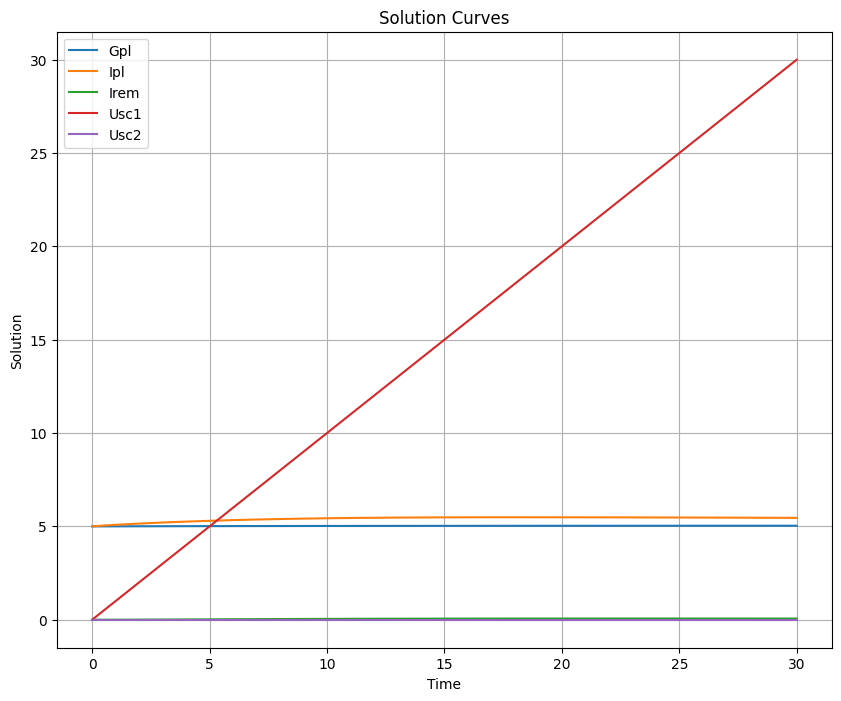

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.integrate import quad
from mpl_toolkits.mplot3d import Axes3D

variables = {
    'k1': 1.45e-2,
    'k2': 2.76e-1,
    'k3': 6.07e-3,
    'k4': 2.35e-4,
    'k5': 9.49e-2,
    'k6': 1.93e-1,
    'k7': 1.15,
    'k8': 7.27,
    'k9': 0,
    'k10': 0,
    'k11': 3.83e-2,
    'k12': 2.84e-1,
    'k13': 0,
    'sigma': 1.34,
    'K_M': 13.2,
    'Gbpl': 5,
    'Ibpl': 5,
    'gbliv': 0.043,
    'Gthpl': 9,
    'vG': 17 / 70,
    'vI': 13 / 70,
    'beta': 1,
    'f': 0.005551,
    'tau_i': 31,
    't_start': 0,
    't_end': 30,
    't_start_ipnc': 0,
    't_end_ipnc': 15,
    'tau_d': 3,
    'c1': 0.1,
    'h': 1,
    't_half': 1,
    'a': 1,
    'b': 1
}

inputs = {
    'Dmeal': 75,
    'Mb': 150,
    'usa': lambda t: 1,
    'Ula': lambda t: 1,
    'h': 2
}

def MGgut(t):
    D_meal = inputs['Dmeal']
    k1 = variables['k1']
    sigma = variables['sigma']
    return D_meal * np.exp(-(k1 * t)**sigma)

def dGpl_dt(t, Gpl, Ipl, Irem, Usc1, Usc2):
    def gliv(Gpl, Irem):
        gbliv = variables['gbliv']
        k3 = variables['k3']
        Gbpl = variables['Gbpl']
        k4 = variables['k4']
        beta = variables['beta'] 
        return gbliv - k3 * (Gpl - Gbpl) - k4 * beta * Irem

    def ggut(MGgut):
        k2 = variables['k2']
        f = variables['f']
        vG = variables['vG']
        Mb = inputs['Mb']
        return k2 * (f / (vG * Mb)) * MGgut

    def gnonit(Gpl):
        gbliv = variables['gbliv']
        KM = variables['K_M']
        Gbpl = variables['Gbpl']
        return gbliv * ((KM + Gbpl) / Gbpl) * (Gpl / (KM + Gpl))

    def git(Gpl, Irem):
        k5 = variables['k5']
        beta = variables['beta']
        KM = variables['K_M']
        return k5 * beta * Irem * (Gpl / (KM + Gpl))

    def gren(Gpl):
        c1 = variables['c1']
        vG = variables['vG']
        Mb = inputs['Mb']
        Gthpl = variables['Gthpl']
        return 0 if Gpl < Gthpl else (c1 / (vG * Mb)) * (Gpl - Gthpl)

    return gliv(Gpl, Irem) + ggut(MGgut(t)) - gnonit(Gpl) - git(Gpl, Irem) - gren(Gpl)

def dUsc1_dt(t, Usc1):
    k10 = variables['k10']
    usa = inputs['usa']
    return usa(t) - k10 * Usc1

def dUsc2_dt(t, Usc1, Usc2):
    k9 = variables['k9']
    k10 = variables['k10']
    return k10 * Usc1 - k9 * Usc2

def dIpl_dt(t, Gpl, Ipl, Irem, Usc1, Usc2):
    def ipnc(t, Gpl, dGpl_dt):
        Gbpl = variables['Gbpl']
        beta = variables['beta']
        k6 = variables['k6']
        k7 = variables['k7']
        tau_i = variables['tau_i']
        k8 = variables['k8']
        tau_d = variables['tau_d']
        t_start = variables['t_start']
        t_end = variables['t_end']
        start = variables['t_start_ipnc']
        end = variables['t_end_ipnc']

        def integrand(x):
            return Gpl - Gbpl

        integral_term, _ = quad(integrand, start, end)
        return (1 / beta) * (k6 * (Gpl - Gbpl) + (k7 / tau_i) * integral_term + (k7 / tau_i) * Gbpl + (k8 * tau_d) * dGpl_dt)

    def isa(t, Usc2):
        k9 = variables['k9']
        vI = variables['vI']
        Mb = inputs['Mb']
        return k9 * (1 / (vI * Mb)) * Usc2

    def ila(t, Ula):
        h = variables['h']
        t_half = variables['t_half']
        vI = variables['vI']
        Mb = inputs['Mb']
        return ((h * (t_half ** h) * (t ** (h - 1))) / (((t_half ** h) + (t ** h)) ** 2)) * ((1 / (vI * Mb)) * Ula(t))

    def iliv(t, Gpl, Ipl):
        k7 = variables['k7']
        beta = variables['beta']
        tau_i = variables['tau_i']
        Ibpl = variables['Ibpl']
        return k7 * (variables['Gbpl'] / (beta * tau_i * Ibpl)) * Ipl

    def irem(t, Ipl):
        k11 = variables['k11']
        Ibpl = variables['Ibpl']
        return k11 * (Ipl - Ibpl)

    return ipnc(t, Gpl, dGpl_dt(t, Gpl, Ipl, Irem, Usc1, Usc2)) + isa(t, Usc2) + ila(t, inputs['Ula']) - iliv(t, Gpl, Ipl) - irem(t, Ipl)

def dIrem_dt(t, Gpl, Ipl, Irem, Usc1, Usc2):
    def ipl(t, Ipl):
        k11 = variables['k11']
        Ibpl = variables['Ibpl']
        return k11 * (Ipl - Ibpl)

    def iit(t, Irem):
        k12 = variables['k12']
        return k12 * Irem

    return ipl(t, Ipl) - iit(t, Irem)

# Define the time span
t_span = (0, 30)

# Define the initial conditions
Gpl0 = 5.0
Ipl0 = 5.0
Irem0 = 0.0
Usc1_0 = 0.0
Usc2_0 = 0.0

# Combine the functions into a single function
def system(t, variables):
    Gpl, Ipl, Irem, Usc1, Usc2 = variables
    dGpl = dGpl_dt(t, Gpl, Ipl, Irem, Usc1, Usc2)
    dIpl = dIpl_dt(t, Gpl, Ipl, Irem, Usc1, Usc2)
    dIrem = dIrem_dt(t, Gpl, Ipl, Irem, Usc1, Usc2)
    dUsc1 = dUsc1_dt(t, Usc1)
    dUsc2 = dUsc2_dt(t, Usc1, Usc2)
    return [dGpl, dIpl, dIrem, dUsc1, dUsc2]

# Solve the system of differential equations
solution = solve_ivp(system, t_span, [Gpl0, Ipl0, Irem0, Usc1_0, Usc2_0], method='LSODA')

# Extract the results
t = solution.t
Gpl = solution.y[0]
Ipl = solution.y[1]
Irem = solution.y[2]
Usc1 = solution.y[3]
Usc2 = solution.y[4]

# Plot solution curves
plt.figure(figsize=(10, 8))
plt.plot(t, Gpl, label='Gpl')
plt.plot(t, Ipl, label='Ipl')
plt.plot(t, Irem, label='Irem')
plt.plot(t, Usc1, label='Usc1')
plt.plot(t, Usc2, label='Usc2')
plt.xlabel('Time')
plt.ylabel('Solution')
plt.title('Solution Curves')
plt.legend()
plt.grid(True)
plt.show()